# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 58147,
  "iopub_port": 40663,
  "stdin_port": 39723,
  "control_port": 34945,
  "hb_port": 50343,
  "ip": "127.0.0.1",
  "key": "a0e91170-1ba9911568297ca81b92e2cc",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-56a73782-aa79-4dd8-83f0-b640ffded5c1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/nominal_ttbar/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)

In [3]:
# prepare Asimov dataset
params = fit_data._parameters
params_pre = fit_data.get_params_init().copy()
asimov_data = dict()
for category, model_data in fit_data._model_data.items():
    # parse lepton selection and jet category
    cat_split = category.split('_')
    sel = cat_split[0]
    jet_cat = '_'.join(cat_split[1:])
    
    # build prefit expectation from model_tensor
    expected_pre, expected_var = fit_data.mixture_model(params_pre.values, category)
    expected_test = fit_data.model_sums(sel, jet_cat) # for testing template removal
    
    asimov_data[category] = (expected_pre, np.sqrt(expected_pre))


In [4]:
# initialize data for likelihood scans and calculation of the NLL covariance
fit_data.veto_list = [
    # baseline
    #'ee_cat_gt2_eq1_b', 'ee_cat_gt2_gt2_b', 
    #'mumu_cat_gt2_eq1_b', 'mumu_cat_gt2_gt2_b', 
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'e4j_cat_gt4_eq1', 'e4j_cat_gt4_gt2'
    #'mu4j_cat_gt4_eq1', 'mu4j_cat_gt4_gt2', 
    #'mu4j_cat_eq3_gt2',
    
    # e/mu DY CR
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    #'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', 'emu_cat_eq1_eq1_a', 
    
    # e+mu WW
    #'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    #'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    #'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    #'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    #'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]
  
fobj = partial(fit_data.objective, 
               data=asimov_data, 
               cost_type='poisson', 
               no_shape=False,
               do_mc_stat=True
              )

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr, corr = fh.calculate_covariance(fobj, params_pre.values)

In [5]:
# plot errors
parameters = fit_data._parameters.copy()
parameters['val_fit'] = fit_data.get_params_init()
parameters['err_fit'] = stderr

# scale branching fraction values
param_mask = np.array(parameters.type == 'poi', dtype=bool)
val_init = parameters.loc[param_mask, 'val_init']
parameters.loc[param_mask, 'err_init'] *= 100/val_init
parameters.loc[param_mask, 'err_fit'] *= 100/val_init

parameters['ratio'] = parameters.err_fit/parameters.err_init

# scale normalization values
param_mask = np.array(parameters.type == 'norm', dtype=bool)
parameters.loc[param_mask, 'err_init'] *= 100
parameters.loc[param_mask, 'err_fit'] *= 100

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# plot nuisance parameter errors and constraints
parameters.set_index('label')
parameters.to_csv('local_data/pulls.csv')

#parameters[['val_init', 'err_init', 'val_fit', 'err_fit']]
parameters[['err_init', 'err_fit', 'ratio']]#.head(4)


,err_init,err_fit,ratio
name,,,
beta_e,100.00,0.98,0.01
beta_mu,100.00,0.64,0.01
beta_tau,100.00,2.01,0.02
beta_h,100.00,0.38,0.00
br_tau_e,0.23,0.23,1.00
br_tau_mu,0.23,0.23,1.00
br_tau_h,0.15,0.15,1.00
lumi,2.50,1.73,0.69
xs_diboson,10.00,9.93,0.99


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

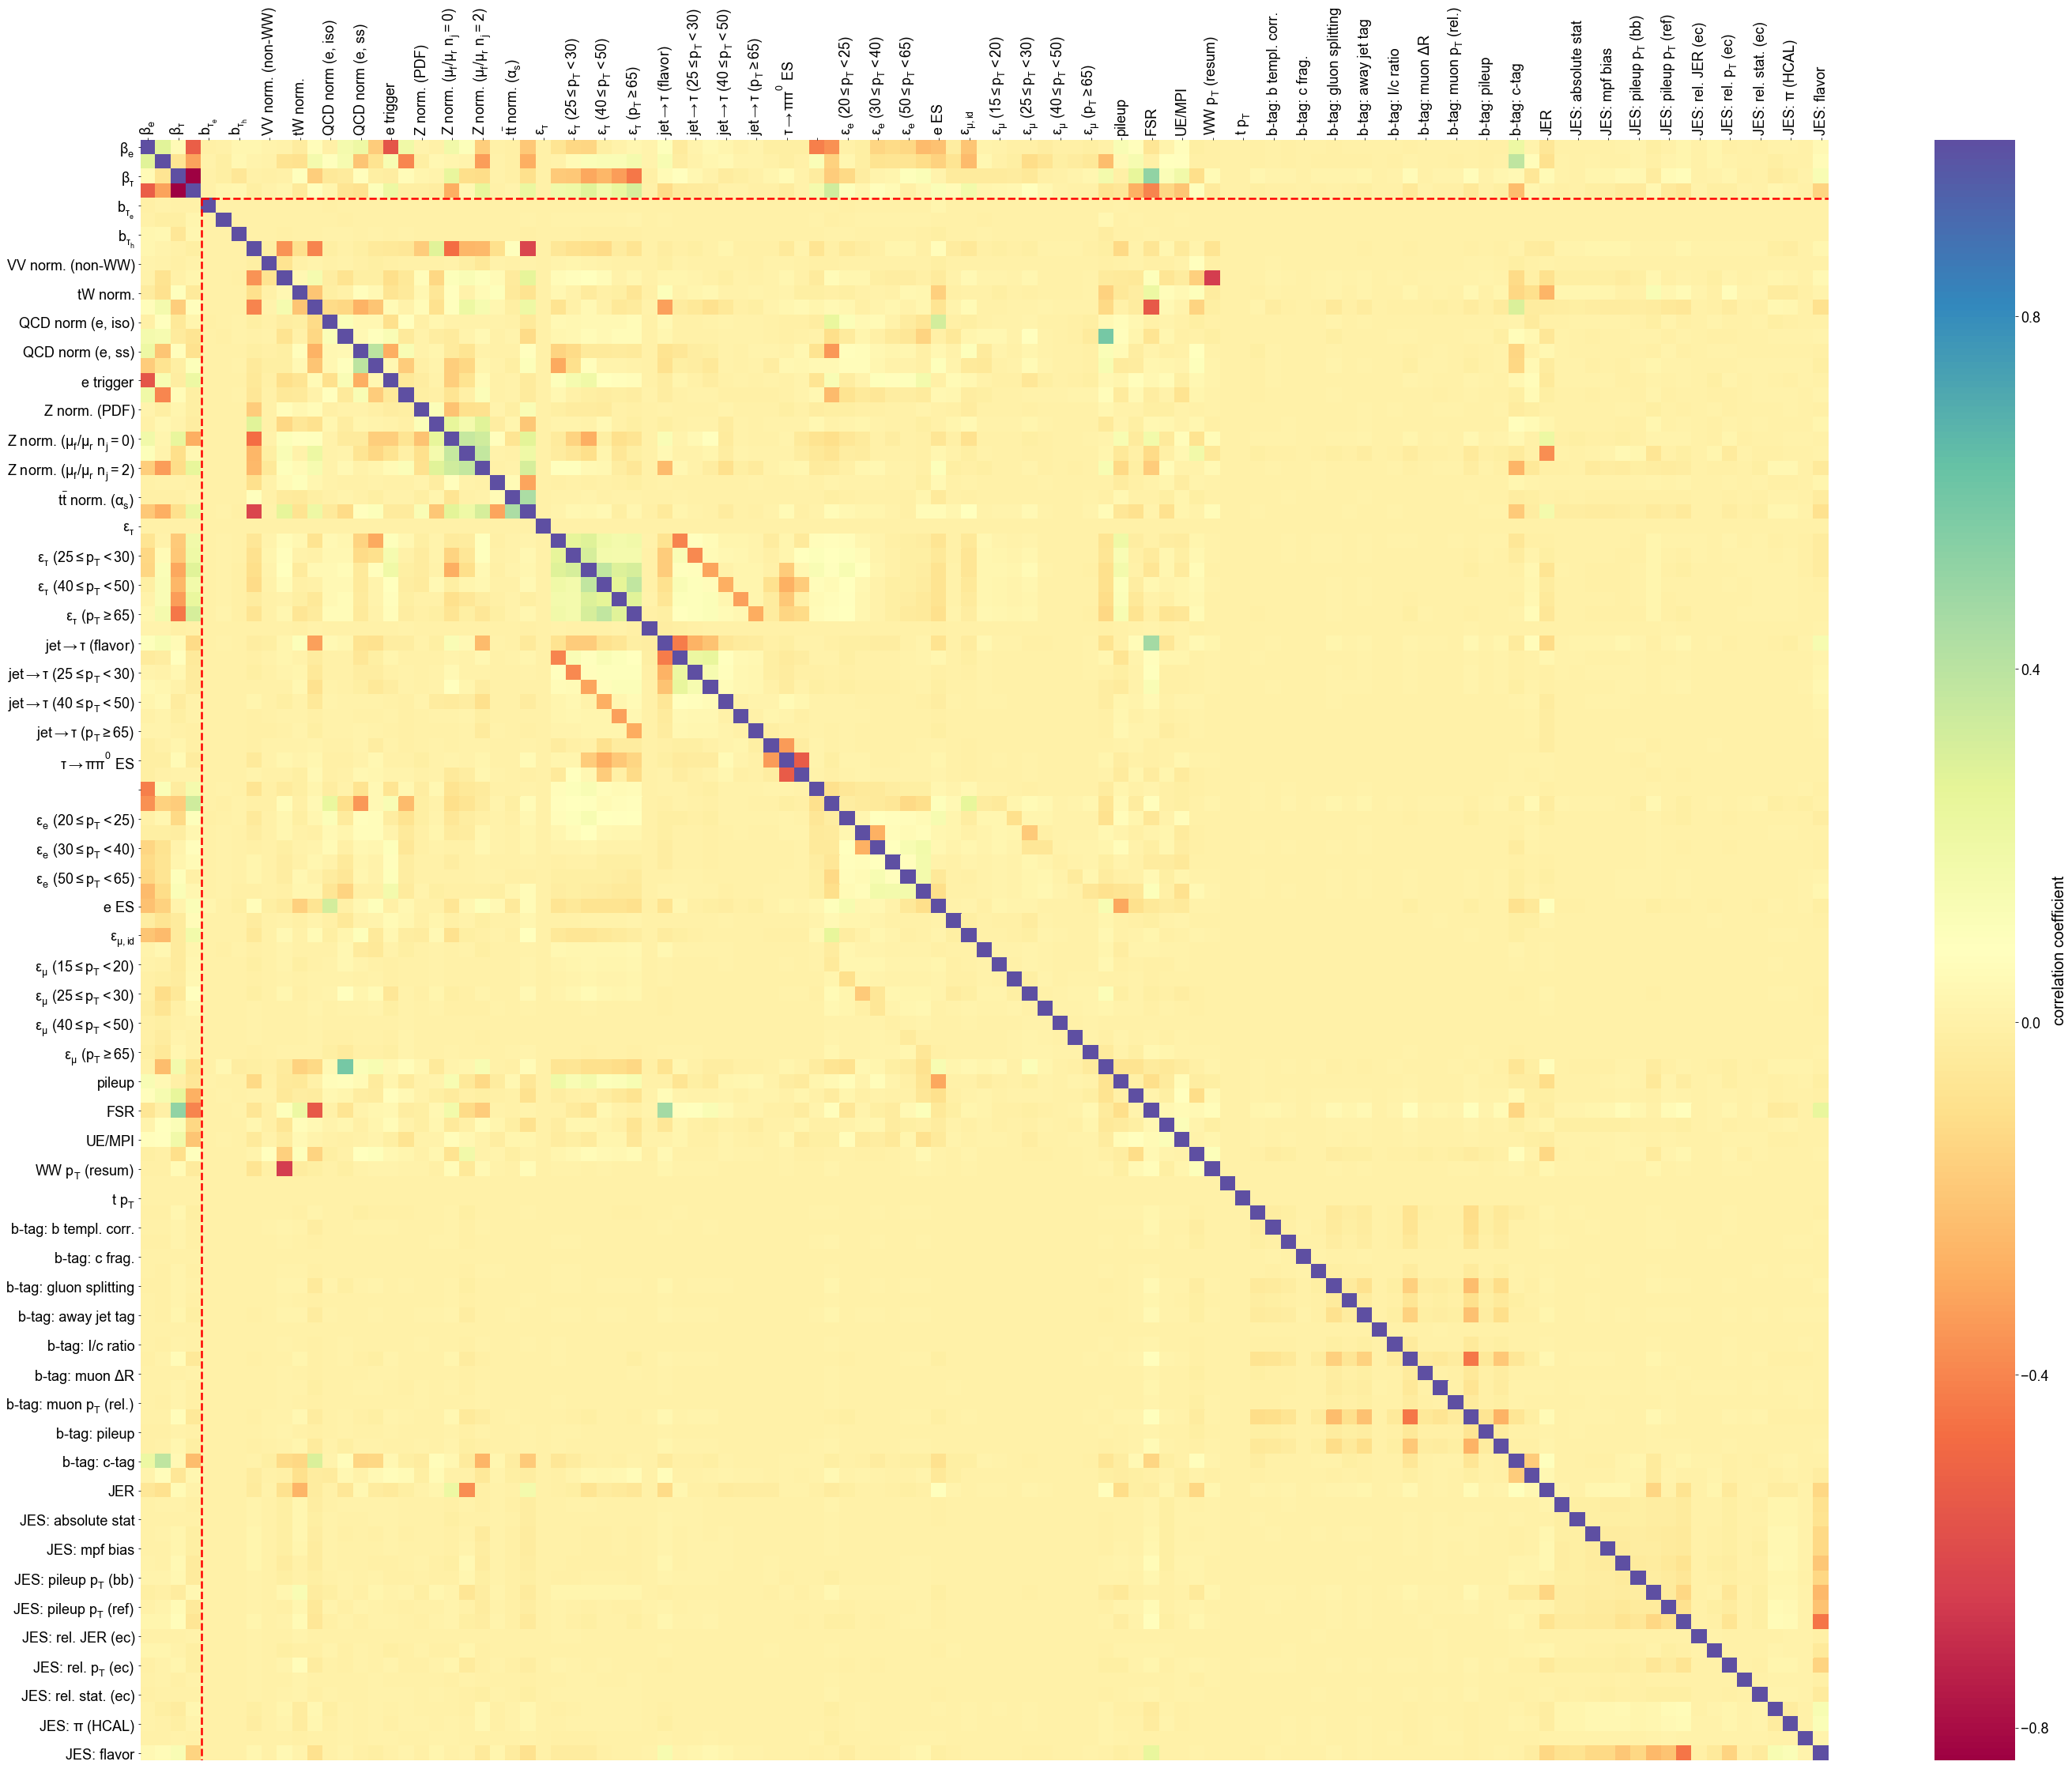

In [6]:
# produce correlation matrix
p_labels_fancy = fit_data._parameters.label
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex('local_data/corr_table_full.tex')
df_corr.to_csv('local_data/corr_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(40, 32))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('plots/systematics/correlation_matrix.pdf')
plt.show()

In [7]:
## n-1 uncertainties
from tqdm import tqdm_notebook, trange
from multiprocessing import Pool

def reduced_objective(p, mask, p_init):
    masked_p = p_init.copy()
    masked_p[mask] = p
    return fit_data.objective(masked_p, data=asimov_data, do_mc_stat=False)

# stat only
params_init = params_pre.values
mask = np.ones(len(params_init)).astype(bool)
mask[4:] = False
fobj = partial(reduced_objective, mask=mask, p_init=params_init)
err_stat, _ = fh.calculate_covariance(fobj, params_init[:4])
err_stat = np.concatenate([err_stat, np.zeros(params_init[4:].size)])

# n-1 systematics
pool = Pool(processes=10)
results = []
for i in range(4, len(params_init)):
    mask = np.ones(len(params_init)).astype(bool)
    mask[i] = False
    fobj = partial(reduced_objective, mask=mask, p_init=params_init)
    #res = pool.apply_async(fh.calculate_covariance, args=(fobj, np.delete(params_init, i)))
    #results.append(res)
    
pool.close()
pool.join()

output = [r.get() for r in results]

In [8]:
# convert to errors
sub_errs = [o[0] for o in output]
errs = np.array([np.concatenate([sub_errs[i-4][:i], [0], sub_errs[i-4][i:]]) for i in range(4, params_init.size)])
errs = np.vstack([err_stat, errs, stderr])
#errs = pd.DataFrame(errs, columns=params.index, index=params.index[4:])
p_labels = list(params.index)
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
#errs.multiply(100)

IndexError: list index out of range

In [ ]:
# print table
beta_vars = errs.iloc[:,:4]**2

for i in trange(1, beta_vars.shape[0] - 1):
    dvar = beta_vars.iloc[-1] - beta_vars.iloc[i]
    beta_vars.iloc[i] = dvar 
    
beta_syst = beta_vars.iloc[-1] - beta_vars.iloc[0]
beta_syst.name = 'syst'
beta_errs = beta_vars.iloc[:-1]
beta_errs = beta_errs.append(beta_syst)
beta_errs = beta_errs.append(beta_vars.iloc[-1])
beta_errs = np.sqrt(beta_errs)

beta_errs.divide(params_init[:4]/100, axis=1).to_latex('local_data/errors.tex')
beta_errs.divide(params_init[:4]/100, axis=1).to_csv('local_data/errors.csv')
beta_errs.divide(params_init[:4]/100, axis=1)

In [ ]:
jes_mask = np.array([True if ('jes' in pname and 'btag' not in pname) else False for pname in beta_errs.index])
btag_mask = np.array([True if 'btag' in pname else False for pname in beta_errs.index])
tau_misid_mask = np.array([True if ('misid_tau' in pname and pname not in ['misid_tau_e', 'misid_tau_h']) else False for pname in beta_errs.index])

btag_errs = beta_errs[btag_mask]
jes_errs = beta_errs[jes_mask]
tau_misid_errs = beta_errs[tau_misid_mask]

summary_errs = beta_errs[~btag_mask&~jes_mask&~tau_misid_mask].copy()
summary_errs.index = [fit_data._parameters.loc[p].label if p in fit_data._parameters.index else p for p in summary_errs.index]
summary_errs.loc['b-tag',:] = np.sqrt(np.sum(btag_errs**2))
summary_errs.loc['JES',:]  = np.sqrt(np.sum(jes_errs**2))
summary_errs.loc[r'$\sf jet\rightarrow\tau$',:]  = np.sqrt(np.sum(tau_misid_errs**2))

summary_errs = summary_errs.divide(params_init[:4]/100, axis=1)
summary_errs.to_latex('local_data/summary_errors.tex', escape=False)
summary_errs.to_csv('local_data/summary_errors.csv')
summary_errs